In [503]:
import pandas as pd
import numpy as np
# from dotenv import load_dotenv
from pandas.tseries.offsets import DateOffset
import os
import requests
import datetime
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.requests import CryptoLatestQuoteRequest
from alpaca.data.requests import CryptoTradesRequest
from alpaca.data.timeframe import TimeFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from numpy.lib import math

%matplotlib inline

## Data Retreival/Formatting

In [504]:
# alpaca_api_key = os.getenv("ALPACA_API_KEY")
# alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [505]:
# type(alpaca_api_key)

In [506]:
crypto_client = CryptoHistoricalDataClient()

In [507]:
request_params = CryptoBarsRequest(
    symbol_or_symbols=["ETH/USD"],
    timeframe=TimeFrame.Hour, start='2021-09-30 00:00:00'
)

eth_bars = crypto_client.get_crypto_bars(request_params)

eth_df = eth_bars.df

eth_df

open    high     low   close    volume  \
symbol  timestamp                                                             
ETH/USD 2021-09-30 00:00:00+00:00  2849.8  2934.8  2838.3  2934.2   706.304   
        2021-09-30 01:00:00+00:00  2935.8  2985.4  2918.2  2961.0   760.251   
        2021-09-30 02:00:00+00:00  2965.4  2994.4  2961.1  2990.6  3886.627   
        2021-09-30 03:00:00+00:00  2992.0  3035.8  2970.0  3029.0  5551.980   
        2021-09-30 04:00:00+00:00  3030.3  3049.2  3014.0  3017.1   401.627   
...                                   ...     ...     ...     ...       ...   
        2022-10-02 17:00:00+00:00  1296.5  1298.2  1295.5  1297.5   220.747   
        2022-10-02 18:00:00+00:00  1297.5  1298.3  1291.6  1296.1   309.480   
        2022-10-02 19:00:00+00:00  1296.1  1313.7  1296.0  1304.6  1631.271   
        2022-10-02 20:00:00+00:00  1304.6  1307.4  1302.8  1302.9   696.048   
        2022-10-02 21:00:00+00:00  1302.9  1303.3  1301.4  1301.4   107.318   

                                   trade_count         vwap  
symbol  timestamp                                            
ETH/USD 2021-09-30 00:00:00+00:00        393.0  2887.453790  
        2021-09-30 01:00:00+00:00        352.0  2957.585712  
        2021-09-30 02:00:00+00:00        573.0  2975.692584  
        2021-09-30 03:00:00+00:00        669.0  2991.111283  
        2021-09-30 04:00:00+00:00        115.0  3030.674760  
...                                        ...          ...  
        2022-10-02 17:00:00+00:00        623.0  1296.583978  
        2022-10-02 18:00:00+00:00        784.0  1294.694793  
        2022-10-02 19:00:00+00:00       1579.0  1304.553769  
        2022-10-02 20:00:00+00:00        845.0  1304.350986  
        2022-10-02 21:00:00+00:00         73.0  1302.197613  

[8812 rows x 7 columns]

In [508]:
eth_df.dtypes

open           float64
high           float64
low            float64
close          float64
volume         float64
trade_count    float64
vwap           float64
dtype: object

In [509]:
eth_df = eth_df.reset_index()
eth_df = eth_df.set_index('timestamp')
eth_df = eth_df.drop(columns=['symbol'])

eth_df

open    high     low   close    volume  \
timestamp                                                             
2021-09-30 00:00:00+00:00  2849.8  2934.8  2838.3  2934.2   706.304   
2021-09-30 01:00:00+00:00  2935.8  2985.4  2918.2  2961.0   760.251   
2021-09-30 02:00:00+00:00  2965.4  2994.4  2961.1  2990.6  3886.627   
2021-09-30 03:00:00+00:00  2992.0  3035.8  2970.0  3029.0  5551.980   
2021-09-30 04:00:00+00:00  3030.3  3049.2  3014.0  3017.1   401.627   
...                           ...     ...     ...     ...       ...   
2022-10-02 17:00:00+00:00  1296.5  1298.2  1295.5  1297.5   220.747   
2022-10-02 18:00:00+00:00  1297.5  1298.3  1291.6  1296.1   309.480   
2022-10-02 19:00:00+00:00  1296.1  1313.7  1296.0  1304.6  1631.271   
2022-10-02 20:00:00+00:00  1304.6  1307.4  1302.8  1302.9   696.048   
2022-10-02 21:00:00+00:00  1302.9  1303.3  1301.4  1301.4   107.318   

                           trade_count         vwap  
timestamp                                            
2021-09-30 00:00:00+00:00        393.0  2887.453790  
2021-09-30 01:00:00+00:00        352.0  2957.585712  
2021-09-30 02:00:00+00:00        573.0  2975.692584  
2021-09-30 03:00:00+00:00        669.0  2991.111283  
2021-09-30 04:00:00+00:00        115.0  3030.674760  
...                                ...          ...  
2022-10-02 17:00:00+00:00        623.0  1296.583978  
2022-10-02 18:00:00+00:00        784.0  1294.694793  
2022-10-02 19:00:00+00:00       1579.0  1304.553769  
2022-10-02 20:00:00+00:00        845.0  1304.350986  
2022-10-02 21:00:00+00:00         73.0  1302.197613  

[8812 rows x 7 columns]

In [510]:
# Use the pct_change function to generate  returns from close prices
eth_df["Actual Returns"] = eth_df["close"].pct_change()

# Drop na
eth_df=eth_df.dropna()

In [583]:
# Initialize the new Signal column
eth_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
eth_df.loc[(eth_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
eth_df.loc[(eth_df['Actual Returns'] < 0), 'Signal'] = 0

eth_df

C:\Users\gtkhh\AppData\Local\Temp\ipykernel_3912\3664761026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_df['Signal'] = 0.0


open    high     low   close    volume  \
timestamp                                                             
2021-09-30 01:00:00+00:00  2935.8  2985.4  2918.2  2961.0   760.251   
2021-09-30 02:00:00+00:00  2965.4  2994.4  2961.1  2990.6  3886.627   
2021-09-30 03:00:00+00:00  2992.0  3035.8  2970.0  3029.0  5551.980   
2021-09-30 04:00:00+00:00  3030.3  3049.2  3014.0  3017.1   401.627   
2021-09-30 05:00:00+00:00  3023.0  3041.3  3019.5  3029.7   141.883   
...                           ...     ...     ...     ...       ...   
2022-10-02 17:00:00+00:00  1296.5  1298.2  1295.5  1297.5   220.747   
2022-10-02 18:00:00+00:00  1297.5  1298.3  1291.6  1296.1   309.480   
2022-10-02 19:00:00+00:00  1296.1  1313.7  1296.0  1304.6  1631.271   
2022-10-02 20:00:00+00:00  1304.6  1307.4  1302.8  1302.9   696.048   
2022-10-02 21:00:00+00:00  1302.9  1303.3  1301.4  1301.4   107.318   

                           trade_count         vwap  Actual Returns  Signal  
timestamp                                                                    
2021-09-30 01:00:00+00:00        352.0  2957.585712        0.009134     1.0  
2021-09-30 02:00:00+00:00        573.0  2975.692584        0.009997     1.0  
2021-09-30 03:00:00+00:00        669.0  2991.111283        0.012840     1.0  
2021-09-30 04:00:00+00:00        115.0  3030.674760       -0.003929     0.0  
2021-09-30 05:00:00+00:00        108.0  3025.002656        0.004176     1.0  
...                                ...          ...             ...     ...  
2022-10-02 17:00:00+00:00        623.0  1296.583978        0.000771     1.0  
2022-10-02 18:00:00+00:00        784.0  1294.694793       -0.001079     0.0  
2022-10-02 19:00:00+00:00       1579.0  1304.553769        0.006558     1.0  
2022-10-02 20:00:00+00:00        845.0  1304.350986       -0.001303     0.0  
2022-10-02 21:00:00+00:00         73.0  1302.197613       -0.001151     0.0  

[8811 rows x 9 columns]

In [584]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = eth_df[['open', 'high','low','close','volume', 'trade_count']].shift().dropna()

# Review the DataFrame
X.head()

open    high     low   close    volume  \
timestamp                                                             
2021-09-30 02:00:00+00:00  2935.8  2985.4  2918.2  2961.0   760.251   
2021-09-30 03:00:00+00:00  2965.4  2994.4  2961.1  2990.6  3886.627   
2021-09-30 04:00:00+00:00  2992.0  3035.8  2970.0  3029.0  5551.980   
2021-09-30 05:00:00+00:00  3030.3  3049.2  3014.0  3017.1   401.627   
2021-09-30 06:00:00+00:00  3023.0  3041.3  3019.5  3029.7   141.883   

                           trade_count  
timestamp                               
2021-09-30 02:00:00+00:00        352.0  
2021-09-30 03:00:00+00:00        573.0  
2021-09-30 04:00:00+00:00        669.0  
2021-09-30 05:00:00+00:00        115.0  
2021-09-30 06:00:00+00:00        108.0

In [585]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaled = scaler.fit_transform(X)

X_scaled

array([[ 0.23191912,  0.2631416 ,  0.23172312,  0.25581595, -0.27406108,
        -0.34590477],
       [ 0.25969116,  0.27155565,  0.27214615,  0.28358699,  0.88075444,
        -0.0311221 ],
       [ 0.28464847,  0.31026026,  0.28053228,  0.31961428,  1.49589974,
         0.10561608],
       ...,
       [-1.30520699, -1.31411832, -1.30095992, -1.30621108, -0.44056612,
         0.26941702],
       [-1.30652054, -1.29972095, -1.29681397, -1.29823629,  0.04767483,
         1.40178003],
       [-1.29854546, -1.30561078, -1.29040659, -1.29983125, -0.29777628,
         0.35630273]])

In [586]:
# get array representation of dataframe
dataset = eth_df.values

# get number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

7049

In [587]:
# create train dataset
train_data = X_scaled[0:training_data_len, :]

# Create blank array
X_train = []
candles = 60

for i in range(candles, len(train_data)):
    X_train.append(train_data[i-candles:i, 0:6])

display(X_train)

# create test dataset
test_data = X_scaled[training_data_len - candles: , :]

# Create blank array
X_test = []

for i in range(candles, len(test_data)):
    X_test.append(test_data[i-candles:i, 0:6])


[array([[ 0.23191912,  0.2631416 ,  0.23172312,  0.25581595, -0.27406108,
         -0.34590477],
        [ 0.25969116,  0.27155565,  0.27214615,  0.28358699,  0.88075444,
         -0.0311221 ],
        [ 0.28464847,  0.31026026,  0.28053228,  0.31961428,  1.49589974,
          0.10561608],
        [ 0.32058324,  0.32278785,  0.3219918 ,  0.30844958, -0.40652901,
         -0.68347714],
        [ 0.31373405,  0.31540218,  0.32717424,  0.32027103, -0.50247281,
         -0.69344763],
        [ 0.32086471,  0.31764593,  0.32773959,  0.31126421, -0.48554421,
         -0.73760267],
        [ 0.31148226,  0.29604987,  0.30408882,  0.29212471, -0.51679952,
         -0.75042187],
        [ 0.29693947,  0.28716838,  0.27224037,  0.27232846, -0.35943143,
         -0.46270196],
        [ 0.27198217,  0.26875096,  0.28251103,  0.27664423, -0.48879658,
         -0.76466543],
        [ 0.27338953,  0.28053063,  0.24849538,  0.2368641 , -0.25971812,
         -0.63077597],
        [ 0.24430395,  0.24481

In [593]:
# Convert lists to array

X_train = np.array(X_train)
X_test = np.array(X_test)

display(len(X_train))
display(len(X_test))
display(X_train)

6989

1761

array([[[ 0.23191912,  0.2631416 ,  0.23172312,  0.25581595,
         -0.27406108, -0.34590477],
        [ 0.25969116,  0.27155565,  0.27214615,  0.28358699,
          0.88075444, -0.0311221 ],
        [ 0.28464847,  0.31026026,  0.28053228,  0.31961428,
          1.49589974,  0.10561608],
        ...,
        [ 0.5602109 ,  0.55314576,  0.57159695,  0.55407314,
         -0.53214682, -0.79457691],
        [ 0.55486291,  0.55473508,  0.56763945,  0.56955362,
         -0.50728951, -0.76324108],
        [ 0.57456605,  0.56445798,  0.58450593,  0.57856044,
         -0.49699235, -0.77036286]],

       [[ 0.25969116,  0.27155565,  0.27214615,  0.28358699,
          0.88075444, -0.0311221 ],
        [ 0.28464847,  0.31026026,  0.28053228,  0.31961428,
          1.49589974,  0.10561608],
        [ 0.32058324,  0.32278785,  0.3219918 ,  0.30844958,
         -0.40652901, -0.68347714],
        ...,
        [ 0.55486291,  0.55473508,  0.56763945,  0.56955362,
         -0.50728951, -0.76324108],
  

In [589]:
# Create the target set selecting the Signal column and assiging it to y
y = eth_df['Signal']

# Review the value counts
display(y)

# Drop first row
y = y.iloc[1:-60]

display(y)

timestamp
2021-09-30 01:00:00+00:00    1.0
2021-09-30 02:00:00+00:00    1.0
2021-09-30 03:00:00+00:00    1.0
2021-09-30 04:00:00+00:00    0.0
2021-09-30 05:00:00+00:00    1.0
                            ... 
2022-10-02 17:00:00+00:00    1.0
2022-10-02 18:00:00+00:00    0.0
2022-10-02 19:00:00+00:00    1.0
2022-10-02 20:00:00+00:00    0.0
2022-10-02 21:00:00+00:00    0.0
Name: Signal, Length: 8811, dtype: float64

timestamp
2021-09-30 02:00:00+00:00    1.0
2021-09-30 03:00:00+00:00    1.0
2021-09-30 04:00:00+00:00    0.0
2021-09-30 05:00:00+00:00    1.0
2021-09-30 06:00:00+00:00    0.0
                            ... 
2022-09-30 05:00:00+00:00    1.0
2022-09-30 06:00:00+00:00    1.0
2022-09-30 07:00:00+00:00    1.0
2022-09-30 08:00:00+00:00    1.0
2022-09-30 09:00:00+00:00    0.0
Name: Signal, Length: 8750, dtype: float64

In [594]:
# Splitting Y data

y_train = y.iloc[0:len(X_train)]
y_test = y.iloc[len(X_train):]

display(y_train.count())
display(y_test.count())

6989

1761

## Model Creation

In [603]:
# Define the the number of inputs (features) to the model
number_input_features = len(X.columns)

# Review the number of features
number_input_features


6

In [604]:
# Create the Sequential model instance
nn = Sequential()

# Define the number of neurons in the output layer
number_output_neurons = 1

# Define the number of hidden nodes for the first hidden layer
# hidden_nodes_layer1 = (number_input_features + 1) // 2
hidden_nodes_layer1 = 64

# Review the number hidden nodes in the first layer
display(hidden_nodes_layer1)

# Define the number of hidden nodes for the second hidden layer
# hidden_nodes_layer2 = (hidden_nodes_layer1 + 1) //2
hidden_nodes_layer2 = 64

# Review the number hidden nodes in the second layer
display(hidden_nodes_layer2)

64

64

In [605]:
# Add the first hidden layer
nn.add(LSTM(units=hidden_nodes_layer1, return_sequences=True, input_dim=number_input_features))

In [606]:
#Add the second hidden layer
nn.add(LSTM(units=hidden_nodes_layer2))


In [607]:
# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units=1,  activation='sigmoid'))


In [608]:
# Display the Sequential model summary
nn.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, None, 64)          18176     
                                                                 
 lstm_37 (LSTM)              (None, 64)                33024     
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 51,265
Trainable params: 51,265
Non-trainable params: 0
_________________________________________________________________


In [609]:
# Compile the Sequential model
# nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=('accuracy','Precision', 'Recall'))

nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=('accuracy'))

In [610]:
# Fit the model using 50 epochs and the training data
model_01 = nn.fit(X_train, y_train, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
197/197 [==============================] - 28s 110ms/step - loss: 0.6967 - accuracy: 0.4914 - val_loss: 0.6971 - val_accuracy: 0.4979
Epoch 2/30
197/197 [==============================] - 21s 109ms/step - loss: 0.6935 - accuracy: 0.5035 - val_loss: 0.6943 - val_accuracy: 0.4979
Epoch 3/30
197/197 [==============================] - 20s 104ms/step - loss: 0.6932 - accuracy: 0.5057 - val_loss: 0.6933 - val_accuracy: 0.4979
Epoch 4/30
197/197 [==============================] - 21s 105ms/step - loss: 0.6930 - accuracy: 0.5111 - val_loss: 0.6940 - val_accuracy: 0.4979
Epoch 5/30
197/197 [==============================] - 20s 104ms/step - loss: 0.6930 - accuracy: 0.5022 - val_loss: 0.6955 - val_accuracy: 0.4979
Epoch 6/30
197/197 [==============================] - 21s 105ms/step - loss: 0.6926 - accuracy: 0.5194 - val_loss: 0.6928 - val_accuracy: 0.4979
Epoch 7/30
197/197 [==============================] - 21s 107ms/step - loss: 0.6930 - accuracy: 0.5017 - val_loss: 0.6964 - val_ac

In [611]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
# model_loss, model_accuracy, model_precision, model_recall = nn.evaluate(X_test, y_test)

model_loss, model_accuracy = nn.evaluate(X_test, y_test)

# Display the model loss and accuracy results
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}, Precision: {model_precision}, Recall: {model_recall}")

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

56/56 [==============================] - 2s 33ms/step - loss: 0.6964 - accuracy: 0.4997
Loss: 0.6963901519775391, Accuracy: 0.4997160732746124


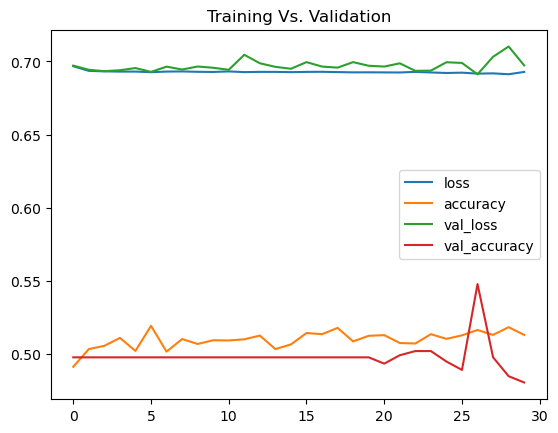

In [612]:
# Train vs test for loss
plt.plot(model_01.history["loss"])
plt.plot(model_01.history["accuracy"])
plt.plot(model_01.history["val_loss"])
plt.plot(model_01.history["val_accuracy"])
plt.title("Training Vs. Validation")
plt.legend(["loss", "accuracy","val_loss","val_accuracy"])
plt.show()